# Quick Start

One can open this tutorial in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/master/docs/source/quick_start.ipynb)

In the given short tutorial, we show the basic steps of working with QGOpt. It is known that an arbitrary two-qubit unitary gate can be decomposed into a sequence of CNOT gates and one qubit gates as it is shown on the tensor diagram below (if the diagram is not displayed here, please open the notebook in Google Colab).![renorm_layer.png](https://github.com/LuchnikovI/QGOpt/blob/master/docs/source/images/gate_decomposition.png?raw=1)

Local unitary gates are elements of the complex Stiefel manifold; thus, the decomposition can be found by minimizing Frobenius distance between a given two qubits unitary gate and its decomposition. In the beginning, let us import some libraries.

First, one needs to import all necessary libraries.

In [ ]:
import tensorflow as tf  # tf 2.x
import matplotlib.pyplot as plt
import math

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

Before considering the main part of the code that solves the problem of gate decomposition, we need to introduce a function that calculates the Kronecker product of two matrices:

In [2]:
def kron(A, B):
    """
    Returns Kronecker product of two square matrices.

    Args:
        A: complex valued tf tensor of shape (dim1, dim1)
        B: complex valued tf tensor of shape (dim2, dim2)

    Returns:
        complex valued tf tensor of shape (dim1 * dim2, dim1 * dim2),
        kronecker product of two matrices
    """
    
    dim1 = A.shape[-1]
    dim2 = B.shape[-1]
    AB = tf.transpose(tf.tensordot(A, B, axes=0), (0, 2, 1, 3))
    return tf.reshape(AB, (dim1 * dim2, dim1 * dim2))

Then we define an example of the complex Stiefel manifold:

In [3]:
m = qgo.manifolds.StiefelManifold()

As a target gate that we want to decompose, we use a randomly generated one:

In [4]:
U = m.random((4, 4), dtype=tf.complex128)

We initialize the initial set of local unitary gates $\{u_{ij}\}_{i,j=1}^{4, 2}$ randomly as a 4th rank tensor:

In [5]:
u = m.random((4, 2, 2, 2), dtype=tf.complex128)

The first two indices of this tensor enumerate a particular one-qubit gate, the last two indices are matrix indices of a gate. We turn this tensor into its real representation in order to make it suitable for an optimizer and wrap it into the TF variable:

In [6]:
u = qgo.manifolds.complex_to_real(u)
u = tf.Variable(u)

We initialize the CNOT gate as follows:

In [7]:
cnot = tf.constant([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, 1],
                    [0, 0, 1, 0]], dtype=tf.complex128)

As a next step we initialize Riemannian Adam optimizer:

In [9]:
lr = 0.2  # optimization step size
# we also pass an example of manifold
# to the optimizer in order to give information
# about constraints to the optimizer
opt = qgo.optimizers.RAdam(m, lr)

Finally, we ran part of code that calculate forward pass, gradients, and optimization step several times until convergence is reached:

In [10]:
# this list will be filled by value of
# error per iteration
err_vs_iter = []

# optimization loop
for _ in range(500):
    with tf.GradientTape() as tape:
        # turning u back into its complex representation
        uc = qgo.manifolds.real_to_complex(u)
        # decomposition
        D = kron(uc[0, 0], uc[0, 1])
        D = cnot @ D
        D = kron(uc[1, 0], uc[1, 1])@ D
        D = cnot @ D
        D = kron(uc[2, 0], uc[2, 1])@ D
        D = cnot @ D
        D = kron(uc[3, 0], uc[3, 1]) @ D
        # loss function
        L = tf.linalg.norm(D - U) ** 2
        L = tf.math.real(L)
    # filling list with history of error
    err_vs_iter.append(tf.math.sqrt(L))
    # gradient from tape
    grad = tape.gradient(L, u)
    # optimization step
    opt.apply_gradients(zip([grad], [u]))

Finally, we plot how error decreases with time

[0, 0] element of the trained gate (-0.034378823704696526-0.46822585286096785j)
[0, 0] element of the true gate (-0.03437882370484857-0.4682258528614082j)


Text(0, 0.5, 'err')

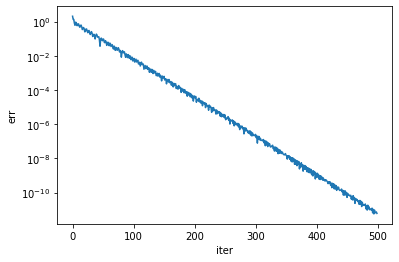

In [11]:
print('[0, 0] element of the trained gate {}'.format(D[0, 0].numpy()))
print('[0, 0] element of the true gate {}'.format(U[0, 0].numpy()))
plt.plot(err_vs_iter)
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')